## Predict historical prices of Brent Oil, Crude Oil WTI, Natural Gas, Heating Oil from 2000-2022 with Fedot.Industrial

Dataset published on Kaggle3 consists of historical prices of Brent Oil, CrudeOil WTI, Natural Gas, and Heating Oil from 2000 to 2022. This sample of DailyOilGasPrices was created by using 30 consecutive business days of **Crude Oil WTI close prices** and **traded volumes** as **predictors** and the **average natural gas close** price during each 30-day time frame as the **target** variable. The final dataset has 191 2-dimensional time series of length 30, of which 70% were randomly sampled as training data and the remaining 30% as testing data. This type of model could help companies and governments to better analyse and predict economic situations and correlations regarding oil and natural gas.
Link to the dataset - https://www.kaggl.com/datasets/prasertk/historical-daily-oil-and-natural-gas-prices

In [21]:
import pandas as pd

from fedot_ind.api.utils.path_lib import PROJECT_PATH
from fedot.core.pipelines.pipeline_builder import PipelineBuilder
from fedot_ind.core.architecture.preprocessing.DatasetLoader import DataLoader
from fedot_ind.core.repository.initializer_industrial_models import IndustrialModels
from examples.example_utils import init_input_data, calculate_regression_metric

The list of basic fedot industrial models for experiment are shown below. We using simple linear machine learning pipelines with 3 different feature generators: Statistical, Reccurence, Topological. And for each of them we add PCA transformation with 90 % of explained dispersion.

In [22]:
model_dict = {
    'regression_with_statistical_features': PipelineBuilder().add_node('quantile_extractor',
                                                                       params={'window_size': 5}).add_node('ridge'),
    'regression_pca_with_statistical_features': PipelineBuilder().add_node('quantile_extractor',
                                                                           params={'window_size': 5}).
    add_node('pca', params={'n_components': 0.9}).add_node('ridge'),
    'regression_with_reccurence_features': PipelineBuilder().add_node('recurrence_extractor',
                                                                           params={'window_size': 20}).add_node('ridge'),
    'regression_pca_with_reccurence_features': PipelineBuilder().add_node('recurrence_extractor',
                                                                           params={'window_size': 20}).
    add_node('pca', params={'n_components': 0.9}).add_node('ridge'),
    'regression_with_topological_features': PipelineBuilder().add_node('topological_extractor',
                                                                           params={'window_size': 20}).
    add_node('pca', params={'n_components': 0.9}).add_node('ridge'),
    'regression_pca_with_topological_features': PipelineBuilder().add_node('topological_extractor',
                                                                           params={'window_size': 20}).
    add_node('pca', params={'n_components': 0.9}).add_node('ridge')
}
metric_dict = {}
dataset_name = 'DailyOilGasPrices'
data_path = PROJECT_PATH + '/examples/data'

Now we must download the dataset. It could be done by using `DataReader` class that implemented as attribute of `FedotIndustrial` class. This class firstly tries to read the data from local project folder `data_path` and then if it is not possible, it downloads the data from the UCR/UEA archive. The data will be saved in the `data` folder.

In [9]:
_, train_data, test_data = DataLoader(dataset_name=dataset_name).read_train_test_files(
            dataset_name=dataset_name,
            data_path=data_path)

2023-10-03 15:10:22,602 - Reading data from D:\WORK\Repo\Industiral\IndustrialTS/examples/data/DailyOilGasPrices


In [11]:
input_data = init_input_data(train_data[0], train_data[1], task='regression')

Lets check our data.

In [14]:
input_data.features.shape

(133, 2, 30)

Lets visualise our predictors.

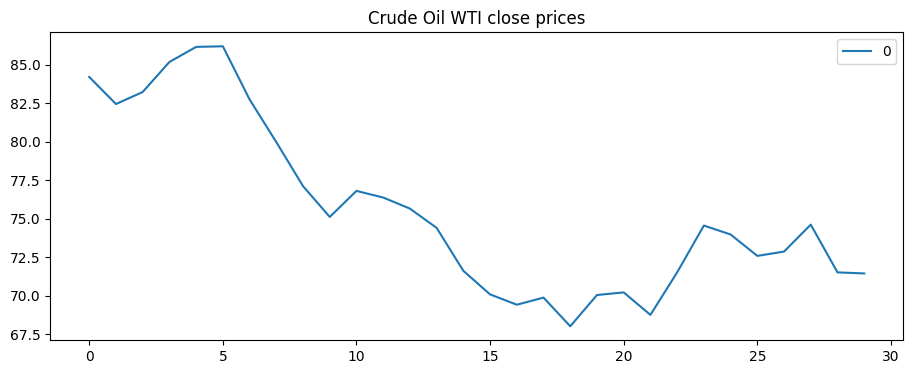

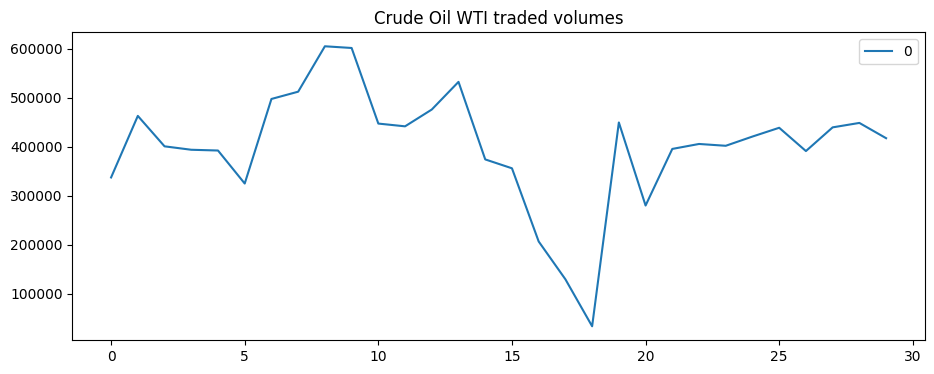

In [23]:
from matplotlib import pyplot as plt
pd.DataFrame(input_data.features[1, 0, :]).plot(title='Crude Oil WTI close prices')
pd.DataFrame(input_data.features[1, 1, :]).plot(title='Crude Oil WTI traded volumes')
plt.show()

Next steps are quite straightforward. We need to fit the model and then predict the values for the test data just like for any other model in sklearn.

At the `fit` stage FedotIndustrial will transform initial time series data into features dataframe and will train regression model.

In [24]:
with IndustrialModels():
    for model in model_dict.keys():
        pipeline = model_dict[model].build()
        input_data = init_input_data(train_data[0], train_data[1], task='regression')
        val_data = init_input_data(test_data[0], test_data[1], task='regression')
        pipeline.fit(input_data)
        features = pipeline.predict(val_data).predict
        metric = calculate_regression_metric(test_target=test_data[1], labels=features)
        metric_dict.update({model: metric})

At the end of the experiment we can obtain the desired metric values using `calculate_regression_metric` method. Now there are five available metrics for classification task:
- `explained_variance_score`
- `max_error`
- `mean_absolute_error`
- `mean_squared_error`
- `d2_absolute_error_score`.
- `median_absolute_error`
- `r2_score`

In [25]:
print(metric_dict)

{'regression_with_statistical_features':                                   0
r2_score:                 -8.678677
mean_squared_error:       31.327938
root_mean_squared_error:   5.597137
mean_absolute_error        3.717366
median_absolute_error      2.020134
explained_variance_score  -8.504791
max_error                 20.534978
d2_absolute_error_score   -1.585878, 'regression_pca_with_statistical_features':                                  0
r2_score:                 0.269194
mean_squared_error:       2.365472
root_mean_squared_error:  1.538009
mean_absolute_error       1.236102
median_absolute_error     1.017146
explained_variance_score  0.270442
max_error                 4.631304
d2_absolute_error_score   0.140141, 'regression_with_reccurence_features':                                  0
r2_score:                 0.052552
mean_squared_error:       3.066698
root_mean_squared_error:  1.751199
mean_absolute_error       1.338562
median_absolute_error     1.045869
explained_variance_score 